In [33]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from helper_functions import set_seeds

In [35]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device 

'cpu'

In [37]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT 

pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

for parameter in pretrained_vit.parameters():
    parameter.requires_grad = True
    
class_names = ['def','ok']

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)


In [38]:
from torchinfo import summary

# Print a summary using torchinfo 
summary(model=pretrained_vit, 
        input_size=(32, 3, 224, 224), 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 2]              768                  True
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              True
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   True
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       7,087,872            True
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 197, 76

In [40]:
import os
import random
from PIL import Image
from pathlib import Path

source_dir = Path("casting_512x512/casting_512x512")
ok_dir = source_dir / "ok_front"
def_dir = source_dir / "def_front"
dest_dir = Path("casting_512x512/dataset")
train_dir = dest_dir / "train"
test_dir = dest_dir / "test"

for path in [train_dir / "ok", train_dir / "def", test_dir / "ok", test_dir / "def"]:
    path.mkdir(parents=True, exist_ok=True)

ok_images = list(ok_dir.glob("*.*"))  
def_images = list(def_dir.glob("*.*"))

all_images = [(img, "ok") for img in ok_images] + [(img, "def") for img in def_images]
random.shuffle(all_images)

selected_images = all_images[:2000]

for i, (img_path, label) in enumerate(selected_images):
    try:
        with Image.open(img_path) as img:
            img_resized = img.resize((224, 224))

        if i < int(0.8 * len(selected_images)):
            split_dir = train_dir
        else:
            split_dir = test_dir

        label_dir = split_dir / label
        output_path = label_dir / img_path.name

        img_resized.save(output_path)
        print(f"Saved image to {output_path}")

    except Exception as e:
        print(f"Failed to process image {img_path}: {e}")

print("Dataset has been created successfully.")


Saved image to casting_512x512/dataset/train/def/cast_def_0_1898.jpeg
Saved image to casting_512x512/dataset/train/ok/cast_ok_0_6482.jpeg
Saved image to casting_512x512/dataset/train/ok/cast_ok_0_2614.jpeg
Saved image to casting_512x512/dataset/train/def/cast_def_0_4363.jpeg
Saved image to casting_512x512/dataset/train/def/cast_def_0_4336.jpeg
Saved image to casting_512x512/dataset/train/def/cast_def_0_3396.jpeg
Saved image to casting_512x512/dataset/train/def/cast_def_0_2102.jpeg
Saved image to casting_512x512/dataset/train/ok/cast_ok_0_1780.jpeg
Saved image to casting_512x512/dataset/train/def/cast_def_0_8149.jpeg
Saved image to casting_512x512/dataset/train/ok/cast_ok_0_4561.jpeg
Saved image to casting_512x512/dataset/train/def/cast_def_0_6738.jpeg
Saved image to casting_512x512/dataset/train/ok/cast_ok_0_9464.jpeg
Saved image to casting_512x512/dataset/train/def/cast_def_0_1616.jpeg
Saved image to casting_512x512/dataset/train/ok/cast_ok_0_9840.jpeg
Saved image to casting_512x512/d

In [43]:
train_dir = 'dataset/train'
test_dir = 'dataset/test'

In [45]:
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [47]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):

  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  class_names = train_data.classes

  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [49]:
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) 

In [51]:
from going_modular.going_modular import engine

optimizer = torch.optim.AdamW(params=pretrained_vit.parameters(), lr=5e-5, weight_decay=1e-4)
loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=15,
                                      device=device)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5747 | train_acc: 0.6478 | test_loss: 0.2376 | test_acc: 0.9464
Epoch: 2 | train_loss: 0.1750 | train_acc: 0.9303 | test_loss: 0.1672 | test_acc: 0.9286
Epoch: 3 | train_loss: 0.1033 | train_acc: 0.9663 | test_loss: 0.2222 | test_acc: 0.9241
Epoch: 4 | train_loss: 0.0486 | train_acc: 0.9844 | test_loss: 0.5988 | test_acc: 0.7848
Epoch: 5 | train_loss: 0.0521 | train_acc: 0.9868 | test_loss: 0.0961 | test_acc: 0.9643
Epoch: 6 | train_loss: 0.0042 | train_acc: 1.0000 | test_loss: 0.1230 | test_acc: 0.9554
Epoch: 7 | train_loss: 0.0010 | train_acc: 1.0000 | test_loss: 0.1122 | test_acc: 0.9688
Epoch: 8 | train_loss: 0.0004 | train_acc: 1.0000 | test_loss: 0.1239 | test_acc: 0.9732
Epoch: 9 | train_loss: 0.0003 | train_acc: 1.0000 | test_loss: 0.1254 | test_acc: 0.9732
Epoch: 10 | train_loss: 0.0002 | train_acc: 1.0000 | test_loss: 0.1245 | test_acc: 0.9732
Epoch: 11 | train_loss: 0.0002 | train_acc: 1.0000 | test_loss: 0.1266 | test_acc: 0.9777
Epoch: 12 | train_l

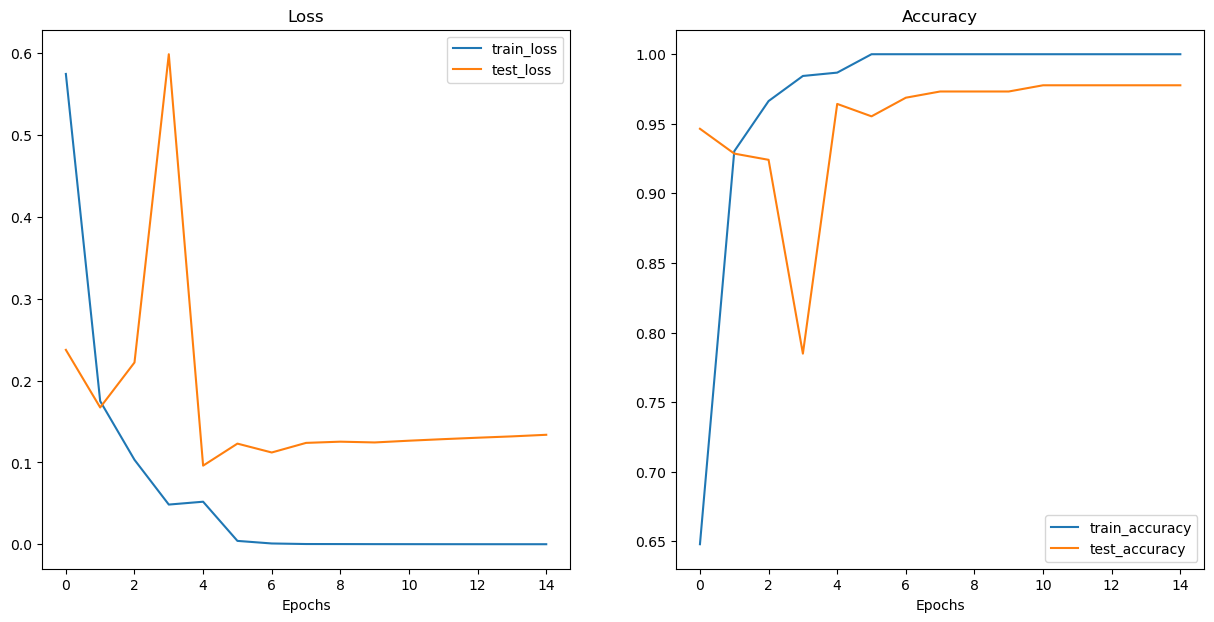

In [53]:
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results) 

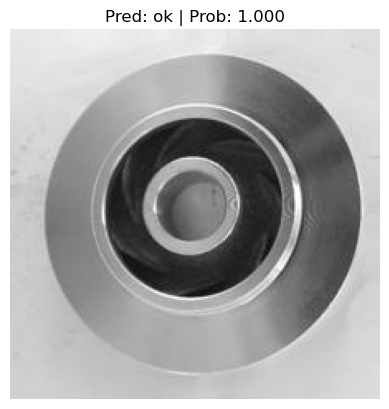

In [55]:
import requests

from going_modular.going_modular.predictions import pred_and_plot_image

custom_image_path = "dataset/train/ok/cast_ok_0_1021.jpeg"

pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

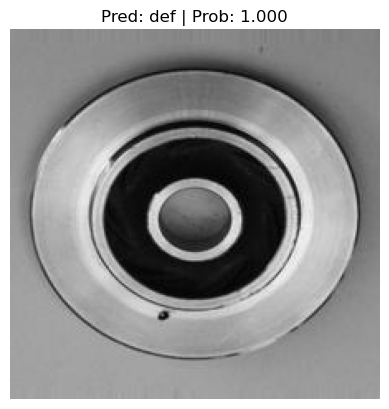

In [57]:
import requests

from going_modular.going_modular.predictions import pred_and_plot_image

custom_image_path = "dataset/train/def/cast_def_0_1015.jpeg"

pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

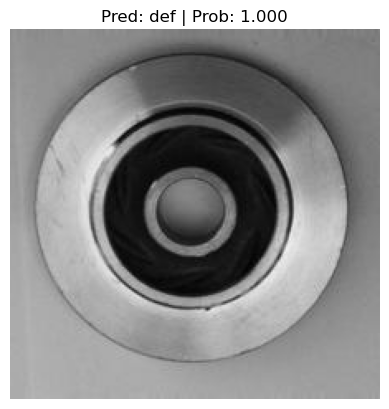

In [59]:
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "dataset/test/def/cast_def_0_1091.jpeg"

pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

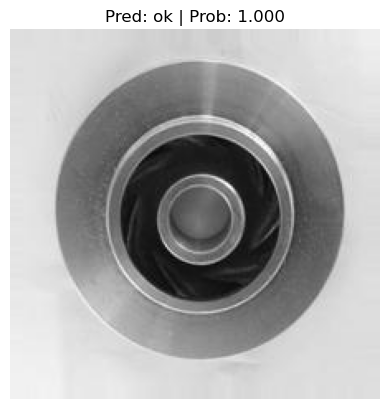

In [61]:
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "dataset/test/ok/cast_ok_0_1761.jpeg"

pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

In [65]:
torch.save(pretrained_vit, "ViTCast_model.pth")


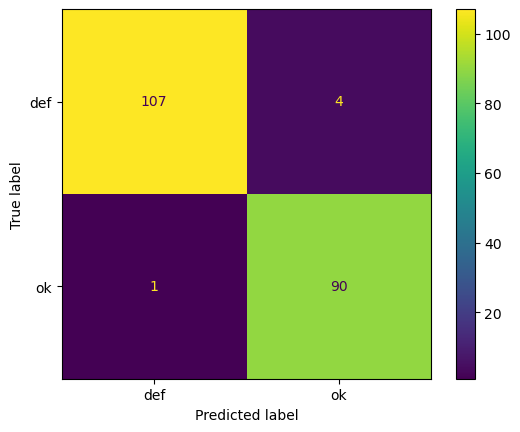

In [63]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch

def compute_confusion_matrix(model, dataloader, class_names, device):
    model.eval()  
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs, 1)  
            all_preds.extend(preds.cpu().numpy())  
            all_labels.extend(labels.cpu().numpy())  

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    return cm

def plot_confusion_matrix(cm, class_names):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="viridis", values_format="d")

cm = compute_confusion_matrix(pretrained_vit, test_dataloader_pretrained, class_names, device)
plot_confusion_matrix(cm, class_names)